In [1]:
from torch.nn import Module, Sequential, Linear, LeakyReLU, Sigmoid, BCELoss
from torch.utils.data import DataLoader, TensorDataset
from torch import device, cuda
from torch.optim import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from time import time
import os

import sys
sys.path.append('..')  
from src.utils.RawDataReader import RawDataReader



In [2]:
reader = RawDataReader()
labels = reader.get_labels()
datasets, means, stds = reader.get_normalised_dataset()

In [3]:
num_labels = labels.shape[1]

validation_split = 0.20
test_split = 0.20
batch_size = 2048 * 4
learning_rate = 0.001
epochs = 99
hidden_layers = 10

num_folds = 10

random_state = 1

device = device("cuda" if cuda.is_available() else "cpu")
print(f"Training on {device}")

Training on cuda


In [4]:
class SingleHeadModel(Module):
    def __init__(self, feature_count:int, hidden_count:int=5):
        super(SingleHeadModel, self).__init__()

        self.slope = 0.001

        self.model = Sequential(
            *[self.linear_block(feature_count,feature_count) for _ in range(hidden_count)],
            Linear(in_features=feature_count, out_features=1),
            Sigmoid()
        )

    def linear_block(self, in_features, out_features):
        return Sequential(
            Linear(in_features=in_features, out_features=out_features),
            LeakyReLU(negative_slope=self.slope)
        )
    
    def forward(self, x):
        return self.model(x)


In [5]:
r = 6
curr_dataset = datasets[r]
mean = means[r]
std = stds[r]
# del datasets
# del means
# del stds

feature_count = curr_dataset.shape[1]

In [6]:
class FusedHeadModel(Module):
    def __init__(self, feature_count:int, hidden_count:int=10, r=None, timestamp=None):
        super(FusedHeadModel, self).__init__()

        self.feature_count = feature_count
        self.timestamp = timestamp
        self.hidden_count = hidden_count
        self.r = r
        self.heads = []

        for _ in range(num_labels):
            self.heads.append(SingleHeadModel(feature_count=self.feature_count))

    def get_singel_head_model_path(self, label):
        return f"../models/{self.timestamp}/SingleHeadModel_norm_{self.hidden_count}hidden_r{self.r}_label{label}.pth"
    
    def get_singel_head_model(self, label):
        path = self.get_singel_head_model_path(label)
        model = SingleHeadModel(
            feature_count=self.feature_count,
            hidden_count=hidden_layers
        ).to(device)
        model.load_state_dict(torch.load(path))

        return model
    
    def forward(self, x):
        output = []
        for _ in range(num_labels):
            pred = self.heads[_](x)
            output.append(pred)
        return torch.cat(output, dim=1)

fused_model = FusedHeadModel(feature_count=datasets[r].shape[1])
fused_model(torch.rand(1,datasets[r].shape[1]))

tensor([[0.4954, 0.5015, 0.4972, 0.5030, 0.4907, 0.5054, 0.5021, 0.5015, 0.5030,
         0.5026, 0.5097, 0.4992, 0.5043, 0.5082, 0.5069, 0.5030, 0.4957, 0.4996,
         0.4955]], grad_fn=<CatBackward0>)

Fold: 9    Epoch: 100%|██████████| 99/99 [00:17<00:00,  5.58it/s]


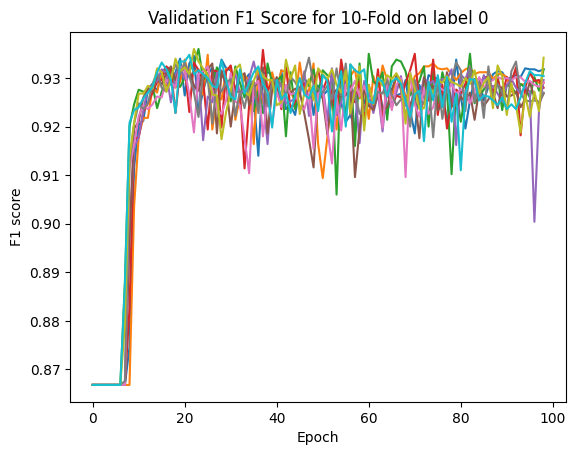

Epoch: 100%|██████████| 198/198 [00:44<00:00,  4.46it/s]


R:6, label:0, --> f1:0.9298


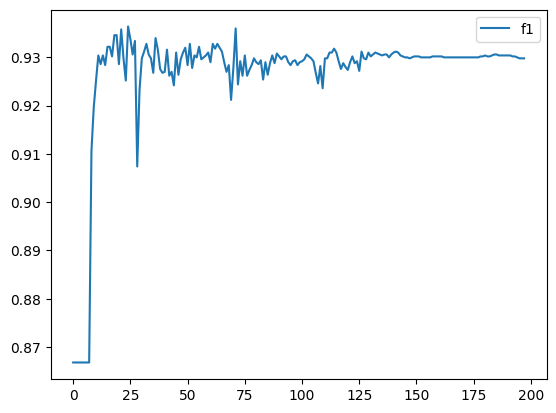

Fold: 9    Epoch: 100%|██████████| 99/99 [00:17<00:00,  5.54it/s]


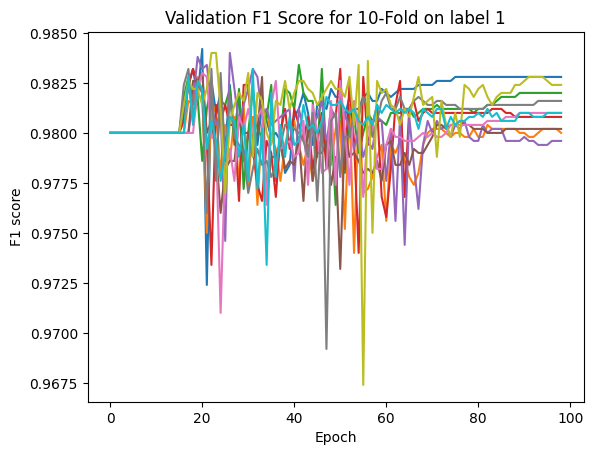

Epoch: 100%|██████████| 198/198 [00:44<00:00,  4.48it/s]


R:6, label:1, --> f1:0.9804


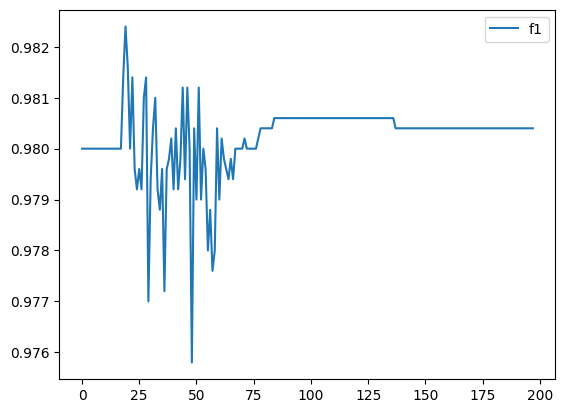

Fold: 9    Epoch: 100%|██████████| 99/99 [00:18<00:00,  5.42it/s]


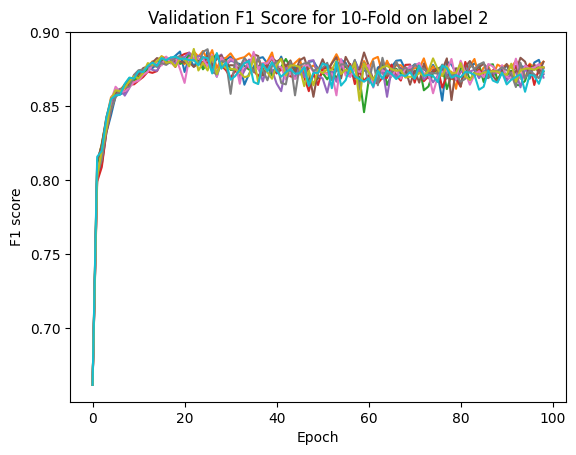

Epoch: 100%|██████████| 198/198 [00:44<00:00,  4.44it/s]


R:6, label:2, --> f1:0.8736000000000002


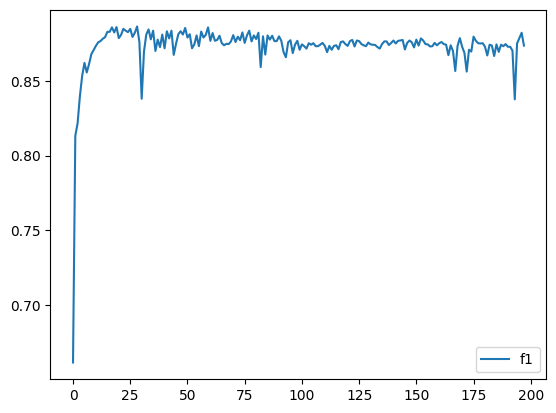

Fold: 9    Epoch: 100%|██████████| 99/99 [00:17<00:00,  5.52it/s]


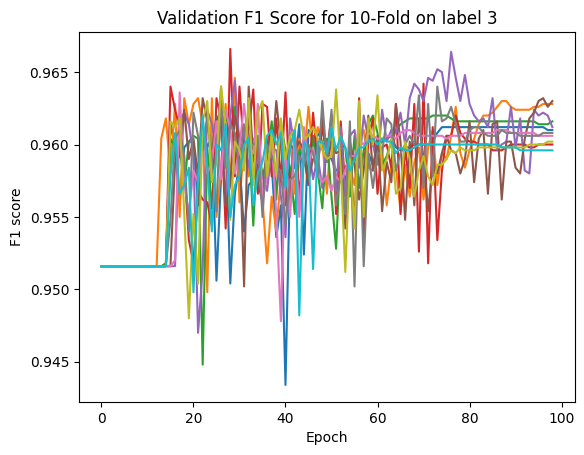

Epoch: 100%|██████████| 198/198 [00:44<00:00,  4.50it/s]

R:6, label:3, --> f1:0.9624


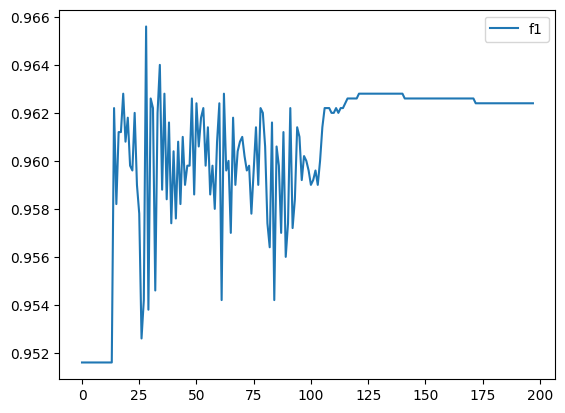

Fold: 9    Epoch: 100%|██████████| 99/99 [00:18<00:00,  5.32it/s]


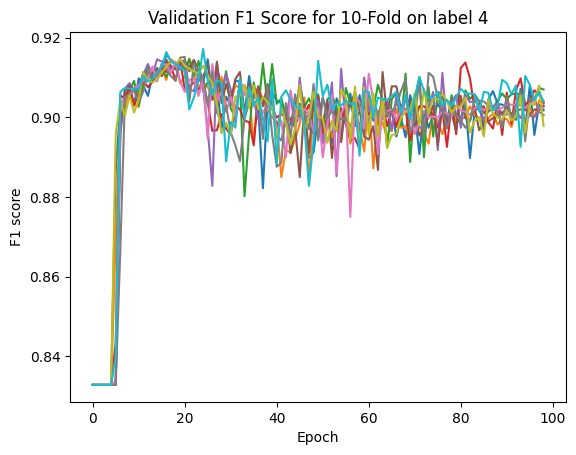

Epoch: 100%|██████████| 198/198 [00:44<00:00,  4.41it/s]

R:6, label:4, --> f1:0.9032


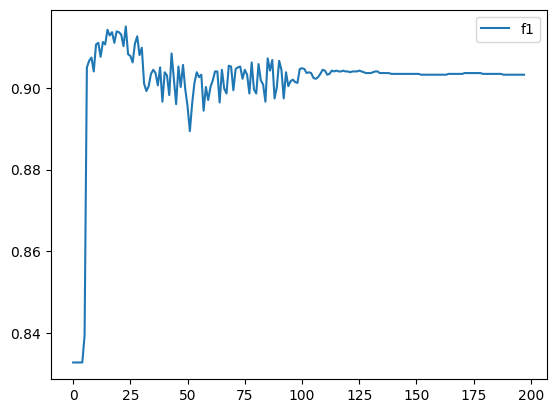

Fold: 9    Epoch: 100%|██████████| 99/99 [00:18<00:00,  5.47it/s]


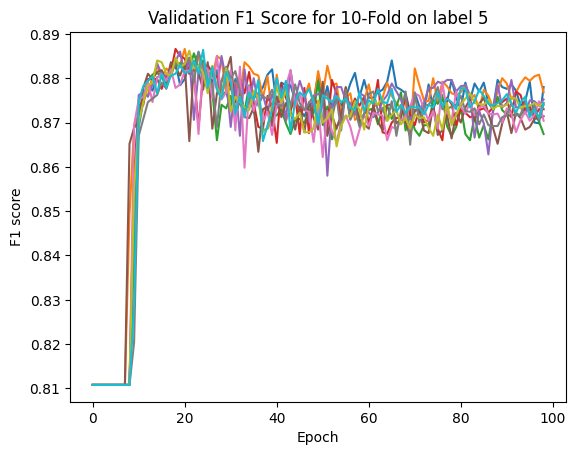

Epoch: 100%|██████████| 198/198 [00:44<00:00,  4.42it/s]

R:6, label:5, --> f1:0.874


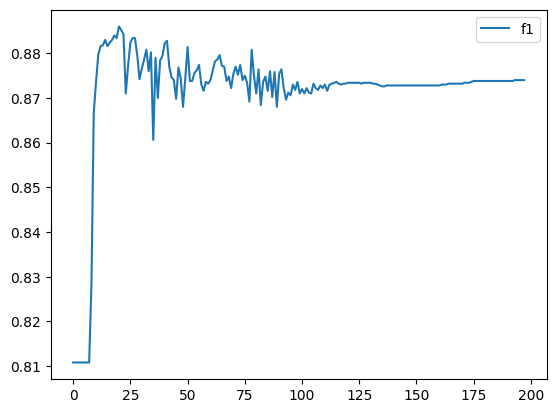

Fold: 9    Epoch: 100%|██████████| 99/99 [00:18<00:00,  5.39it/s]


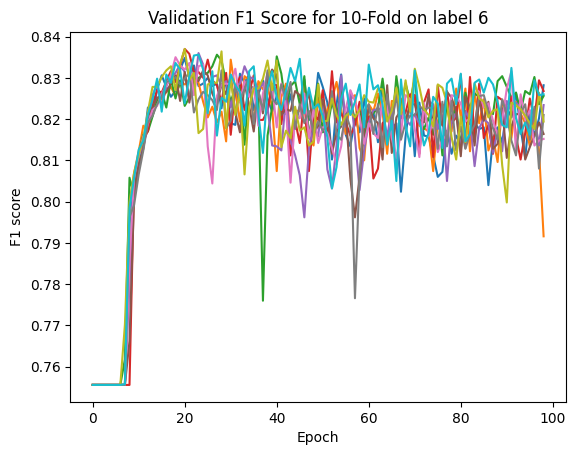

Epoch: 100%|██████████| 198/198 [00:44<00:00,  4.44it/s]

R:6, label:6, --> f1:0.8296


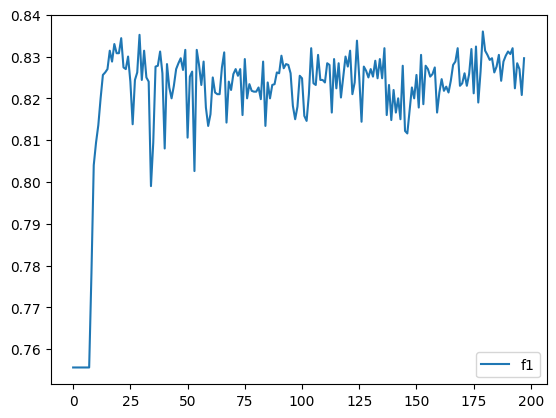

Fold: 9    Epoch: 100%|██████████| 99/99 [00:18<00:00,  5.43it/s]


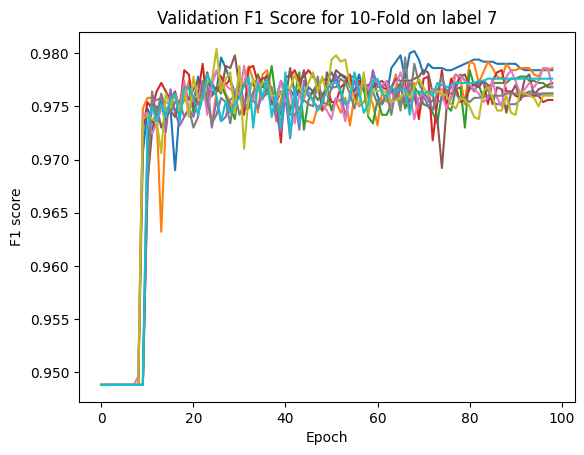

Epoch: 100%|██████████| 198/198 [00:43<00:00,  4.53it/s]

R:6, label:7, --> f1:0.979


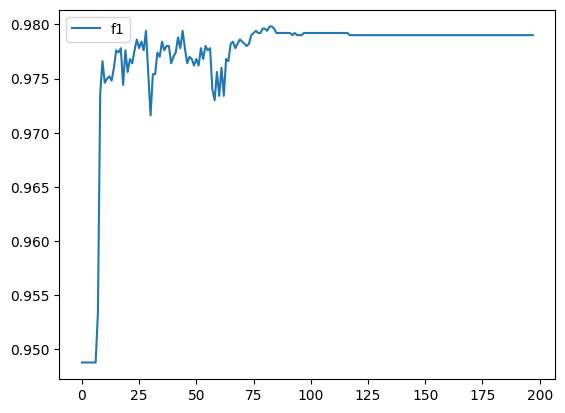

Fold: 9    Epoch: 100%|██████████| 99/99 [00:18<00:00,  5.37it/s]


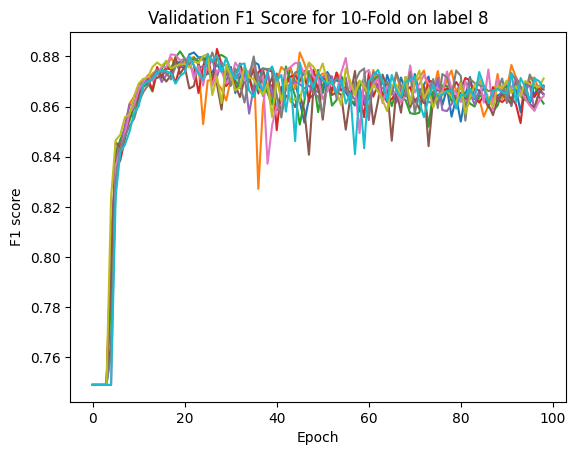

Epoch: 100%|██████████| 198/198 [00:44<00:00,  4.41it/s]

R:6, label:8, --> f1:0.866


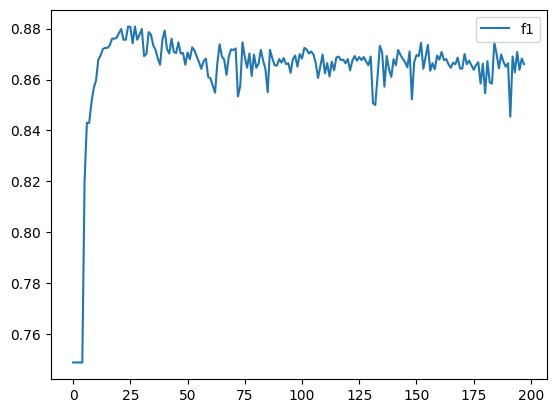

Fold: 9    Epoch: 100%|██████████| 99/99 [00:20<00:00,  4.88it/s]


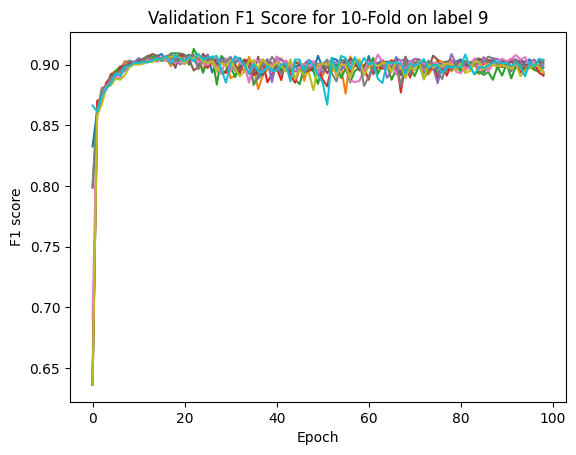

Epoch: 100%|██████████| 198/198 [00:50<00:00,  3.93it/s]


R:6, label:9, --> f1:0.8952000000000001


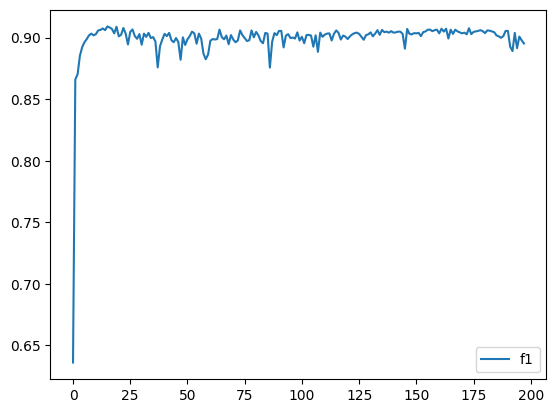

Fold: 9    Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.65it/s]


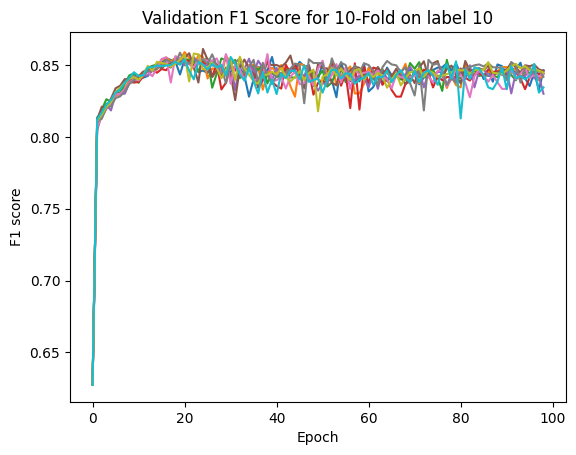

Epoch: 100%|██████████| 198/198 [00:50<00:00,  3.92it/s]

R:6, label:10, --> f1:0.8428


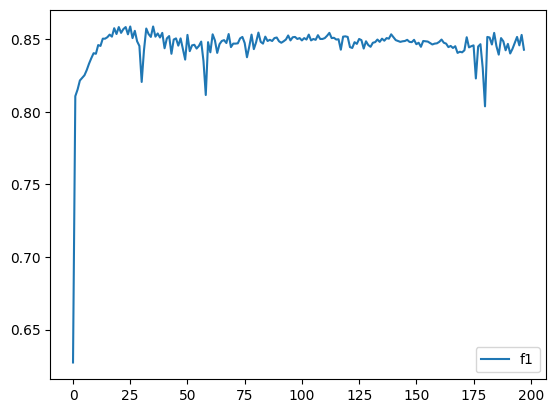

Fold: 9    Epoch: 100%|██████████| 99/99 [00:18<00:00,  5.36it/s]


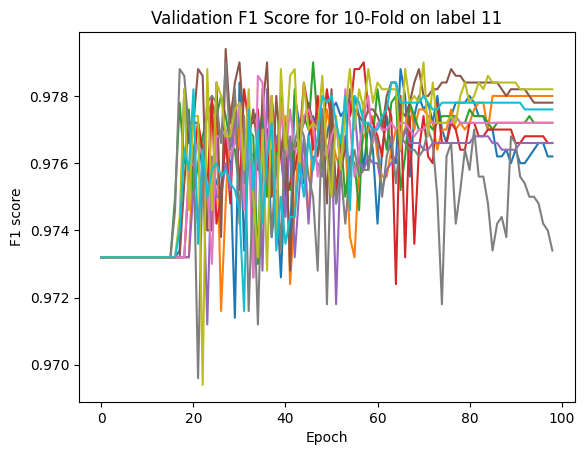

Epoch: 100%|██████████| 198/198 [00:43<00:00,  4.53it/s]


R:6, label:11, --> f1:0.9778


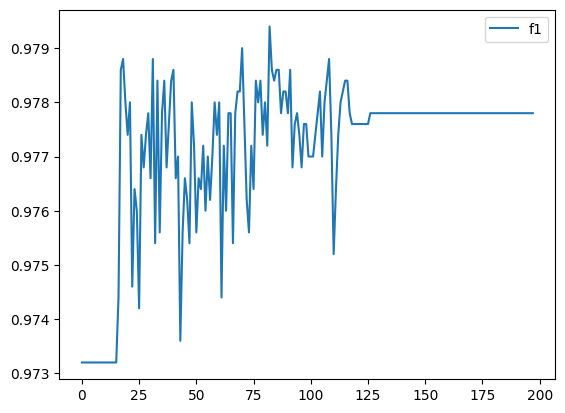

Fold: 9    Epoch: 100%|██████████| 99/99 [00:18<00:00,  5.32it/s]


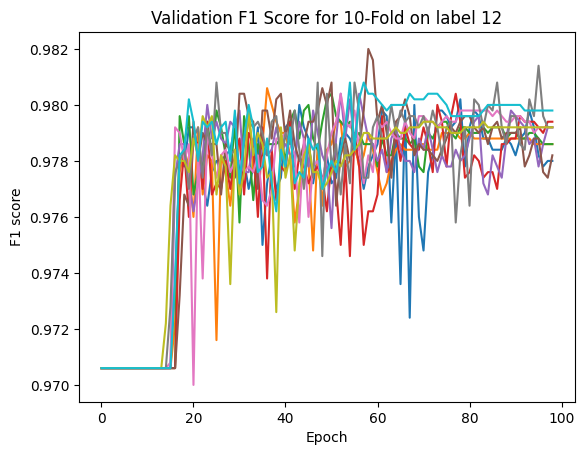

Epoch: 100%|██████████| 198/198 [00:44<00:00,  4.42it/s]


R:6, label:12, --> f1:0.9776


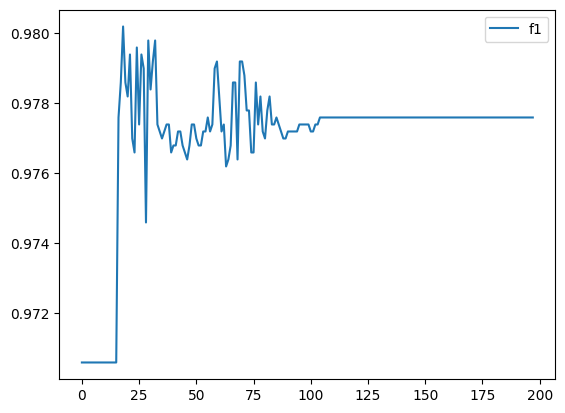

Fold: 9    Epoch: 100%|██████████| 99/99 [00:18<00:00,  5.22it/s]


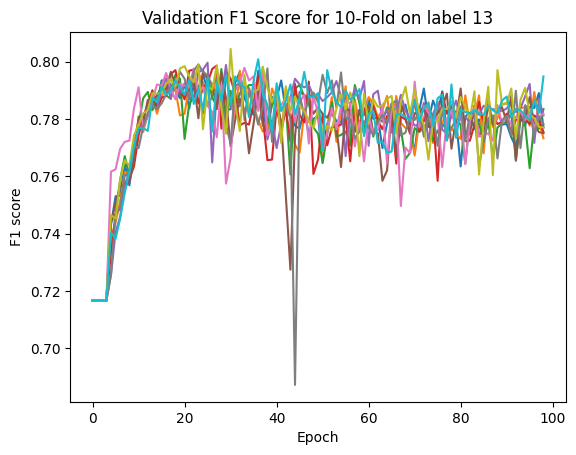

Epoch: 100%|██████████| 198/198 [00:44<00:00,  4.44it/s]

R:6, label:13, --> f1:0.7838


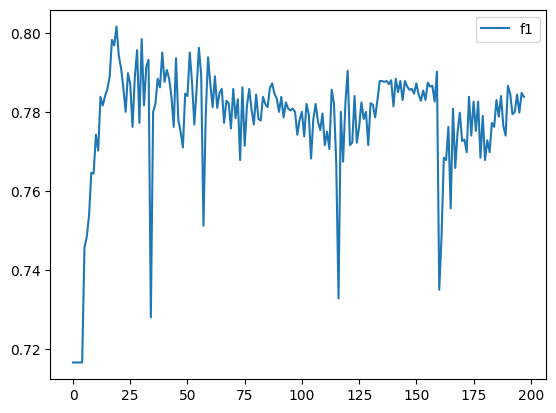

Fold: 9    Epoch: 100%|██████████| 99/99 [00:18<00:00,  5.34it/s]


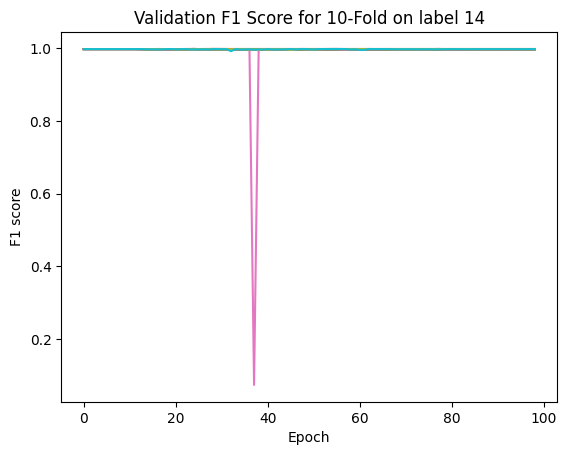

Epoch: 100%|██████████| 198/198 [00:44<00:00,  4.43it/s]

R:6, label:14, --> f1:0.9972


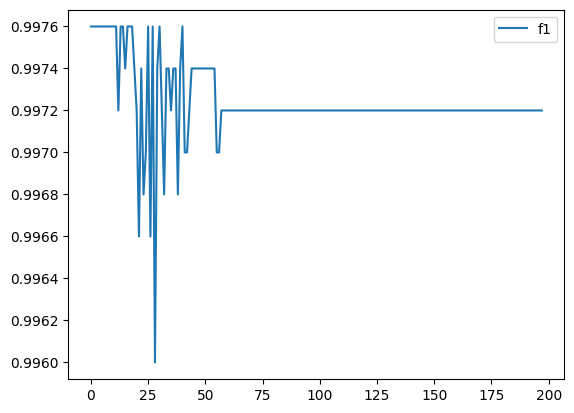

Fold: 9    Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.57it/s]


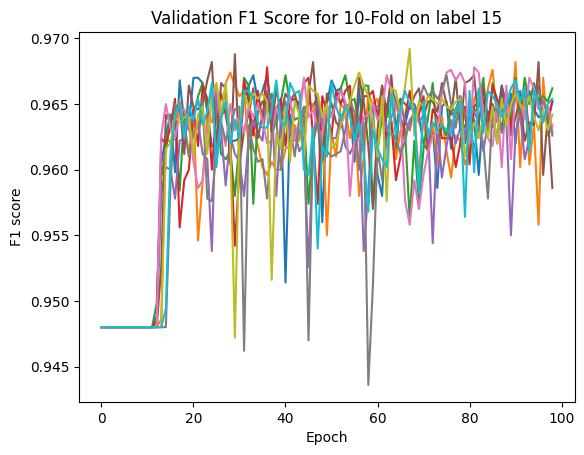

Epoch: 100%|██████████| 198/198 [00:50<00:00,  3.92it/s]

R:6, label:15, --> f1:0.9664


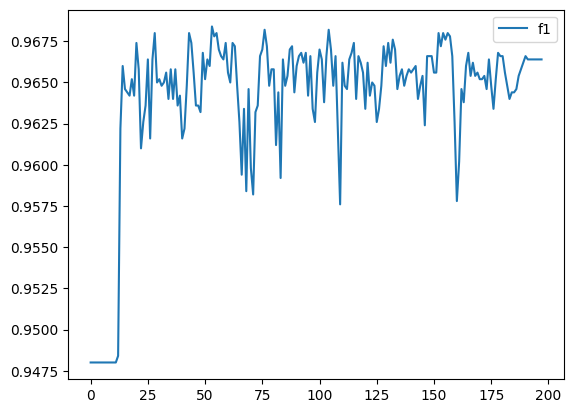

Fold: 9    Epoch: 100%|██████████| 99/99 [00:21<00:00,  4.65it/s]


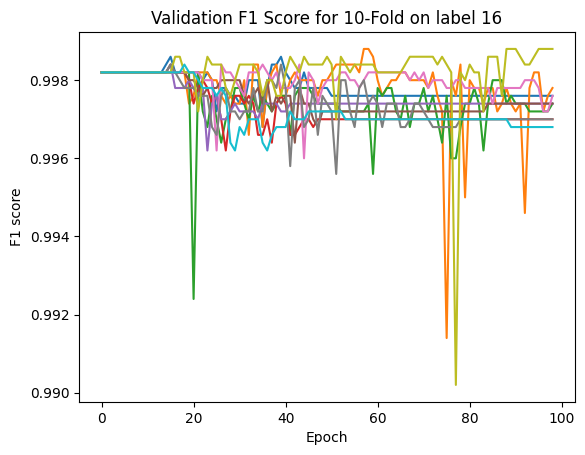

Epoch: 100%|██████████| 198/198 [00:50<00:00,  3.93it/s]

R:6, label:16, --> f1:0.9972


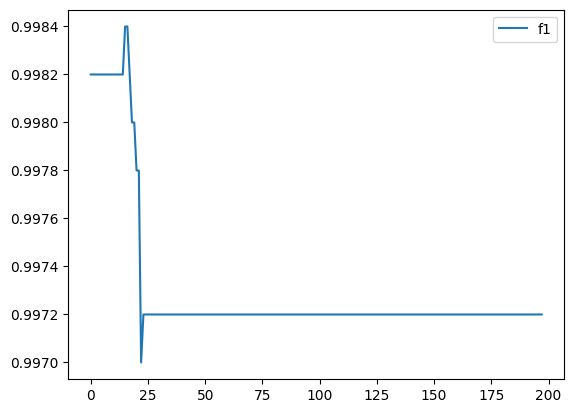

Fold: 9    Epoch: 100%|██████████| 99/99 [00:18<00:00,  5.47it/s]


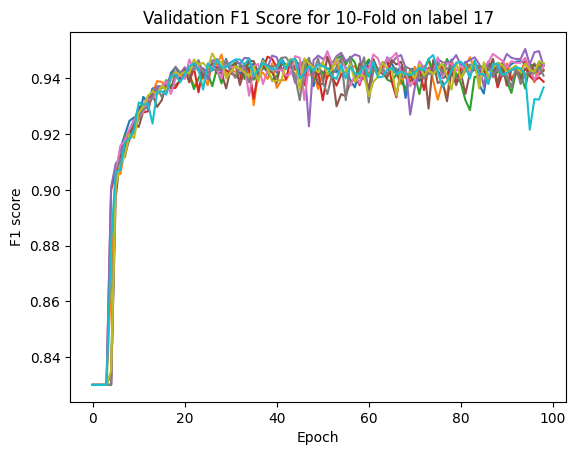

Epoch: 100%|██████████| 198/198 [00:46<00:00,  4.28it/s]


R:6, label:17, --> f1:0.9461999999999999


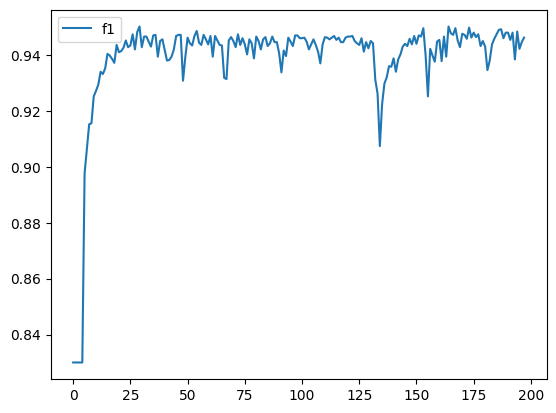

Fold: 9    Epoch: 100%|██████████| 99/99 [00:16<00:00,  6.12it/s]


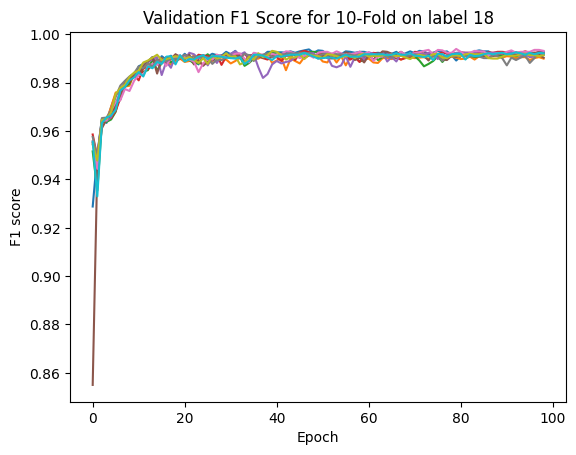

Epoch: 100%|██████████| 198/198 [00:42<00:00,  4.71it/s]


R:6, label:18, --> f1:0.9924


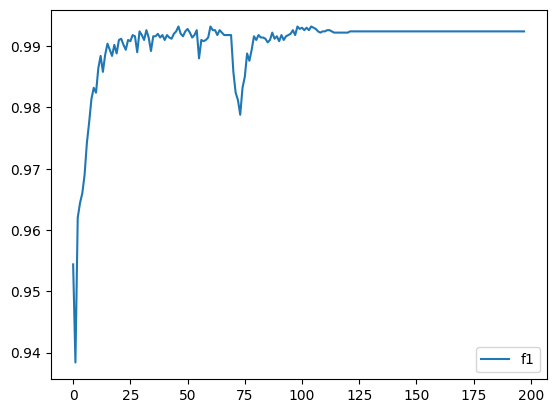

In [7]:
k_fold = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)


for label_index in range(num_labels):
    curr_label = labels[:,[label_index]]
    x, x_val, y, y_val = train_test_split(curr_dataset, curr_label, test_size=validation_split, random_state=random_state)

    x_val = x_val.to(device)
    y_val = y_val.to(device)
    
    f1_scores = {}
    f1_score_validations = {}
    for fold_index, (train_index, test_index) in enumerate(k_fold.split(y)):
        x_train = x[train_index].to(device)
        y_train = y[train_index].to(device)
        train_dataset = TensorDataset(x_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        x_test = x[test_index]
        y_test = y[test_index]

        model = SingleHeadModel(feature_count=feature_count)
        model.to(device)
        
        criterion = BCELoss().to(device)
        optimizer = Adam(model.parameters(), lr=learning_rate)

        for epoch in tqdm(range(epochs), ascii=False, desc=f"Fold: {fold_index}    Epoch"):
            model.train()
            total_loss = 0
            for batch_features, batch_labels in train_loader:
                optimizer.zero_grad()
                predictions = model(batch_features)
                loss = criterion(predictions, batch_labels)
                loss.backward()
                optimizer.step()
                total_loss += loss
                total_loss = total_loss / len(train_loader)

            model.eval()
            y_test_pred = model(x_test.to(device))
            f1 = f1_score(y_test.cpu().detach(), (y_test_pred.cpu().detach()>0.5).float(),average='micro')
            f1_scores[(epoch, fold_index)] = f1
            y_val_pred = model(x_val.to(device))
            f1 = f1_score(y_val.cpu().detach(), (y_val_pred.cpu().detach()>0.5).float(),average='micro')
            f1_score_validations[(epoch, fold_index)] = f1

        model.to('cpu')
        x_train.to('cpu')
        y_train.to('cpu')
        x_test.to('cpu')
        y_test.to('cpu')
        del model
        del x_train
        del y_train
        del x_test
        del y_test
        del optimizer
        del criterion
        del train_dataset
        del train_loader

    fold_f1_df = pd.DataFrame(
        index=f1_scores.keys(),
        data={
            "f1_train": f1_scores.values(),
            "f1_val": f1_score_validations.values()
            },
    )  
    fold_f1_df = fold_f1_df.reset_index()[["level_0", "level_1", "f1_train", "f1_val"]].groupby(["level_0", "level_1"]).sum().unstack()  
    fold_f1_df["f1_val"].plot(
        legend=False,
        xlabel="Epoch",
        ylabel="F1 score",
        title=f"Validation F1 Score for {num_folds}-Fold on label {label_index}"
    )
    plt.show()
    fold_f1_df.to_csv(f"../data/recordes/R{r}_label{label_index}.csv")

    model = fused_model.heads[label_index].to(device)
    criterion = BCELoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    x.to(device)
    y.to(device)
    train_dataset = TensorDataset(x, y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    validation_f1_scores = []
    for epoch in tqdm(range(2*epochs), ascii=False, desc=f"Epoch"):
        model.train()
        total_loss = 0
        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_features.to(device))
            loss = criterion(predictions, batch_labels.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss
            total_loss = total_loss / len(train_loader)

        model.eval()
        y_val_pred = model(x_val.to(device))
        f1 = f1_score(y_val.cpu().detach(), (y_val_pred.cpu().detach()>0.5).float(),average='micro')
        validation_f1_scores.append(f1)

    model.to('cpu')
    x.to('cpu')
    y.to('cpu')
    x_val.to('cpu')
    y_val.to('cpu')
    del x
    del y
    del x_val
    del y_val
    del optimizer
    del criterion
    del train_dataset
    del train_loader

    print(f"R:{r}, label:{label_index}, --> f1:{f1}")
    trained_f1 = pd.DataFrame({
        "f1": validation_f1_scores
    })
    trained_f1.plot()
    plt.show()
    trained_f1.to_csv(f"../data/recordes/R{r}_label{label_index}_trained.csv")



In [8]:
curr_time = time()
os.mkdir(f"../models/{curr_time}")

torch.save(fused_model.state_dict(), f"../models/{curr_time}/R{r}_model.pth")

In [9]:
# curr_time = '1701454903.1140416'
# prediction_array = []

# steps = 50

# for label in range(19):
#     model = SingleHeadModel(
#         feature_count=feature_count,
#         hidden_count=hidden_layers
#     ).to(device)
#     model.load_state_dict(torch.load(f'../models/{curr_time}/SingleHeadModel_norm_{hidden_layers}hidden_r{r}_label{label}.pth'))
    
#     model.eval()
#     predictions = (model(curr_dataset.to(device)) > 0.5).float()
#     prediction_array.append(predictions)
#     # predictions.sum()
#     # # labels[:,[label]].sum()

#     predictions = predictions.to("cpu")
#     c_labels = labels[:,[label]]
#     tp = []
#     tn = []
#     fp = []
#     fn = []
#     thresholds = np.array(range(steps))/steps

#     for theta in thresholds:
#         tn_, fp_, fn_, tp_ = confusion_matrix(c_labels, (predictions > theta).float()).ravel()
#         tn.append(tn_)
#         fp.append(fp_)
#         fn.append(fn_)
#         tp.append(tp_)
 
#     plt.plot(thresholds, tn, label='TN')
#     plt.plot(thresholds, fn, label='FN')
#     plt.plot(thresholds, tp, label='TP')
#     plt.plot(thresholds, fp, label='FP')
#     plt.xlabel('Threshold')
#     plt.ylabel('Count')
#     plt.title(f'Distribution for label {label}')
#     plt.legend()
#     plt.show()
